# Trajectory View

## Configurations

In [1]:
from sys import stdout

import time
import random
import mdtraj
import nglview
import pandas
import numpy as np
import matplotlib.pyplot as plt

from openmm import *
from tqdm.auto import tqdm
from matplotlib import animation 
from openmm.app import *
from openmm.unit import *
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_dir = "../data"
IMAGE_SIZE = "400px"

## View trajectory

In [3]:
molecule = "ad-c5"
result_dir = f"../log/{molecule}"
date = "0814-19:24:18"

molecule = "alanine"
state = "c5"

<Axes: xlabel='#"Time (ps)"'>

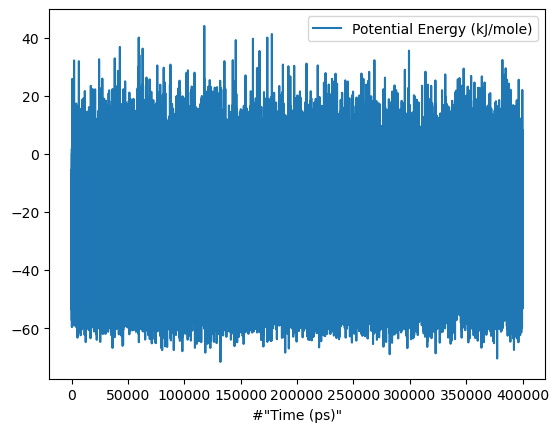

In [4]:
df1 = pandas.read_csv(f"{result_dir}/{date}/scalars.csv")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)")

In [ ]:
start = time.time()
print("Loading trajectory...")
traj_ad = mdtraj.load(
    f"{result_dir}/{date}/traj.dcd",
    top=f"{data_dir}/alanine/{state}.pdb"
)
end = time.time()
print(f"<--- {end-start} seconds --->")

print("Showing trajectory...")
traj_ad.superpose(traj_ad, 0)
nglview.show_mdtraj(traj_ad, width=IMAGE_SIZE, height=IMAGE_SIZE)
end2 = time.time()
print(f"<--- {end2-end} seconds --->")

Loading trajectory...
<--- 696.8790719509125 seconds --->
Showing trajectory...


In [ ]:
def plot_ramachandran(traj, phi_start=None, psi_start=None):
    from matplotlib.gridspec import GridSpec

    phis = mdtraj.compute_phi(traj)[1].ravel()
    psis = mdtraj.compute_psi(traj)[1].ravel()

    fig = plt.figure()
    gs = GridSpec(nrows=3, ncols=3)
    
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.scatter(phi_start * 180 / np.pi, psi_start * 180 / np.pi, s=20, color="red", zorder=0)
    ax1.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist2d(np.arange(len(phis)), phis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist2d(np.arange(len(phis)), psis * 180 / np.pi, 100, norm=LogNorm(), zorder=1)
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")

    fig.tight_layout()

state_file = f"{data_dir}/{molecule}/{state}.pdb"
state_traj = mdtraj.load(state_file)
psi_start = mdtraj.compute_psi(state_traj)[1].ravel()[0]
phi_start = mdtraj.compute_phi(state_traj)[1].ravel()[0]

In [ ]:
plot_ramachandran(
    traj_ad,
    phi_start = phi_start,
    psi_start = psi_start
)

## Traj with states

In [ ]:
molecule = "alanine"
state_list = ["C7eq", "C5", "C7ax", "Beta 2", "Alpha R", "Alpha L", "Beta", "Alpha '", "Alpha D"]
psi_list = [73, 150, -58, 25, -23, 30, 134, -48, -155]
phi_list = [-83, -150, 74, -123, -75, 67, -58, -170, 62]
colors = ["#C40C0C", "#FF6500", "#FF8A08", "#FF0080", "#46244C", "#AD49E1", "#7A1CAC", "#433D8B", "#15F5BA"  ]

# for _ in range(len(state_list)):
#     colors.append("#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]))

# for state in state_list:
#     state_file = f"{data_dir}/{molecule}/{state}.pdb"
#     state_traj = mdtraj.load(state_file)
#     psi = mdtraj.compute_psi(state_traj)[1].ravel()[0]
#     phi = mdtraj.compute_phi(state_traj)[1].ravel()[0]
#     psi_list.append(psi * 180 / np.pi)
#     phi_list.append(phi * 180 / np.pi)

In [ ]:
def plot_ram_with_states(traj, phi_list, psi_list):
    fig = plt.figure()
    fig, ax1 = plt.subplots(figsize=(6,6))
    num_points = len(state_list)

    from matplotlib.gridspec import GridSpec

    phis = mdtraj.compute_phi(traj)[1].ravel()
    psis = mdtraj.compute_psi(traj)[1].ravel()
    
    # Ramachandran plot
    ax1.hist2d(phis * 180 / np.pi, psis * 180 / np.pi, 100, norm=LogNorm())
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    
    for idx in range(num_points):
        ax1.scatter(phi_list[idx], psi_list[idx], s=200, color=colors[idx], label=state_list[idx], zorder=1)
    
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")

    ax1.legend()
    fig.tight_layout()

plot_ram_with_states(traj_ad, phi_list, psi_list)